In [ ]:
!rm -rf *
!git config --global user.name "Akhilez"
!git config --global user.email "akhild18@yahoo.com"
!git clone https://github.com/Akhilez/ml_gallery.git
%cd ml_gallery/ml_py

Cloning into 'ml_gallery'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (522/522), done.
remote: Compressing objects: 100% (361/361), done.
remote: Total 2049 (delta 305), reused 330 (delta 147), pack-reused 1527
Receiving objects: 100% (2049/2049), 11.66 MiB | 7.09 MiB/s, done.
Resolving deltas: 100% (1243/1243), done.
/content/ml_gallery/ml_py


In [ ]:
import os
os.environ['SECRET_KEY'] = '1234'
%mkdir -p data/mnist/numbers

In [ ]:
import torch
from torch.nn.functional import relu
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
aug = MNISTAug()
dm = DataManager()
dm.load()

Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10000)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [ ]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

[{'class': tensor(3),
  'class_one_hot': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  'cx': 28.5,
  'cy': 75.5,
  'height': 17,
  'width': 17,
  'x1': 20,
  'x2': 37,
  'y1': 67,
  'y2': 84}]

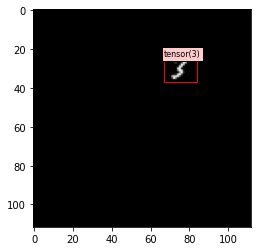

In [ ]:
DataManager.plot_num(x_train[1].reshape((112, 112)), y_train[1])
y_train[1]

In [ ]:
anchor_cx = 56
anchor_cy = 56
anchor_w = 28

In [ ]:
def units_to_diff(y):
    y_d = []
    for i in range(len(y)):
        cx_d = (y[i][0]['cx'] - anchor_cx) / 112
        cy_d = (y[i][0]['cy'] - anchor_cy) / 112
        w_d = (y[i][0]['width'] - anchor_w) / 112
        y_d.append((cx_d, cy_d, w_d))
    return torch.tensor(y_d)

def diff_to_units(y):
    y_units = []
    for i in range(len(y)):
        cx_d = y[i][0] * 112 + anchor_cx
        cy_d = y[i][1] * 112 + anchor_cy
        wd = y[i][2] * 112 + anchor_w
        y_units.append((cx_d, cy_d, wd))
    return torch.tensor(y_units)

In [ ]:
y_d = units_to_diff(y_train)
y_d_test = units_to_diff(y_test)

In [ ]:
class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.linear2 = torch.nn.Linear(4096, 512)
        self.linear3 = torch.nn.Linear(512, 3)

    def forward(self, x):
        x = relu(self.conv1(x))  # 112
        x = relu(self.conv2(x))  # 56
        x = relu(self.conv3(x))  # 28
        x = relu(self.conv4(x))  # 14
        x = relu(self.conv5(x))  # 7
        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

model = DetectorV1().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
epochs = 100
batch_size = 100

for epoch in range(epochs):
    
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_d[start_index:end_index].to(device)
        
        optimizer.zero_grad()

        y_hat = model(x_batch)

        loss = sum(sum((y_batch - y_hat)**2))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch}, loss={float(loss)}')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0, loss=0.16823479533195496
Epoch: 1, loss=0.10180797427892685
Epoch: 2, loss=0.10015550255775452
Epoch: 3, loss=0.07467661798000336
Epoch: 4, loss=0.07522343099117279
Epoch: 5, loss=0.0731273889541626
Epoch: 6, loss=0.1418144404888153
Epoch: 7, loss=0.04398808628320694
Epoch: 8, loss=0.05635416507720947
Epoch: 9, loss=0.04011496528983116
Epoch: 10, loss=0.029763929545879364
Epoch: 11, loss=0.04689549654722214
Epoch: 12, loss=0.030234280973672867
Epoch: 13, loss=0.02477845549583435
Epoch: 14, loss=0.03813482075929642
Epoch: 15, loss=0.03009878471493721
Epoch: 16, loss=0.028555791825056076
Epoch: 17, loss=0.023446427658200264
Epoch: 18, loss=0.030766725540161133
Epoch: 19, loss=0.04641591012477875
Epoch: 20, loss=0.03584263473749161
Epoch: 21, loss=0.03443138673901558
Epoch: 22, loss=1.0625619888305664
Epoch: 23, loss=0.049681104719638824
Epoch: 24, loss=0.02707039564847946
Epoch: 25, loss=0.044279154390096664
Epoch: 26, loss=0.019792985171079636
Epoch: 27, loss=0.021597247570753

y_pred: tensor([[ 0.3252,  0.2031,  0.0520],
        [-0.2833,  0.3075,  0.0184]], device='cuda:0')
y_d_test: tensor([[ 0.3259,  0.1830,  0.0268],
        [-0.2812,  0.2634, -0.0089]])
[{'x1': 75.51124572753906, 'y1': 61.83416748046875, 'x2': 109.33619689941406, 'y2': 95.65911865234375}]
[{'x1': 9.240846633911133, 'y1': 75.41117858886719, 'x2': 39.298545837402344, 'y2': 105.4688720703125}]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


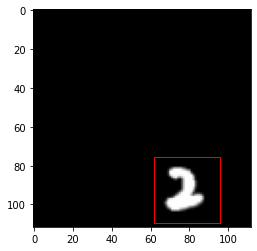

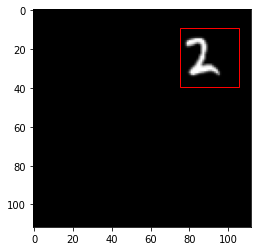

In [ ]:
with torch.no_grad():
    y_pred = model(x_test.to(device))
    
    print(f'y_pred: {y_pred}\ny_d_test: {y_d_test}')
    
    y_pred = diff_to_units(y_pred)
    for i in range(len(y_pred)):

        cx_pred, cy_pred, w_pred = y_pred[i]
        pred_boxes = [{
            'x1': float(cx_pred - w_pred / 2),
            'y1': float(cy_pred - w_pred / 2),
            'x2': float(cx_pred + w_pred / 2),
            'y2': float(cy_pred + w_pred / 2)
        }]

        # pred_boxes.extend(list(y_test[i]))
        print(f'{pred_boxes}')

        DataManager.plot_num(x_test[i].reshape((112, 112)), pred_boxes)


In [ ]:
torch.save(model, 'model.pt')
torch.save(model.state_dict(), 'model_weights.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DetectorV1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
from google.colab import files

In [ ]:
files.download('model.pt')
# files.download('model_weights.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -lah .

total 813M
drwxr-xr-x 8 root root 4.0K Jun 28 20:17 .
drwxr-xr-x 5 root root 4.0K Jun 28 19:58 ..
-rw-r--r-- 1 root root  288 Jun 28 19:58 app.yaml
drwxr-xr-x 3 root root 4.0K Jun 28 19:58 data
drwxr-xr-x 2 root root 4.0K Jun 28 19:58 deploy
-rw-r--r-- 1 root root  407 Jun 28 19:58 Dockerfile
-rw-r--r-- 1 root root   62 Jun 28 19:58 .dockerignore
drwxr-xr-x 8 root root 4.0K Jun 28 19:58 experiments
-rw-r--r-- 1 root root   68 Jun 28 19:58 .gcloudignore
-rw-r--r-- 1 root root 1.1K Jun 28 19:58 .gitignore
drwxr-xr-x 6 root root 4.0K Jun 28 19:58 lib
-rw-r--r-- 1 root root  625 Jun 28 19:58 manage.py
drwxr-xr-x 5 root root 4.0K Jun 28 19:58 MLGallery
drwxr-xr-x 3 root root 4.0K Jun 28 19:58 ml_py
-rw-r--r-- 1 root root 407M Jun 28 20:17 model.pt
-rw-r--r-- 1 root root 407M Jun 28 20:17 model_weights.pt
-rw-r--r-- 1 root root  299 Jun 28 19:58 requirements.txt
-rw-r--r-- 1 root root   19 Jun 28 19:58 secondary_requirements.txt
